<a href="https://colab.research.google.com/github/chambeda/ml_finance/blob/main/EWMA_and_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-02-24 17:22:42--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-02-24 17:22:42 (37.8 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

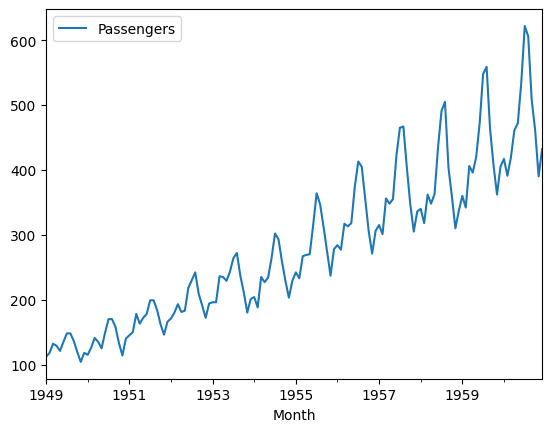

In [6]:
df.plot();

In [7]:
alpha = 0.2

In [8]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [9]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

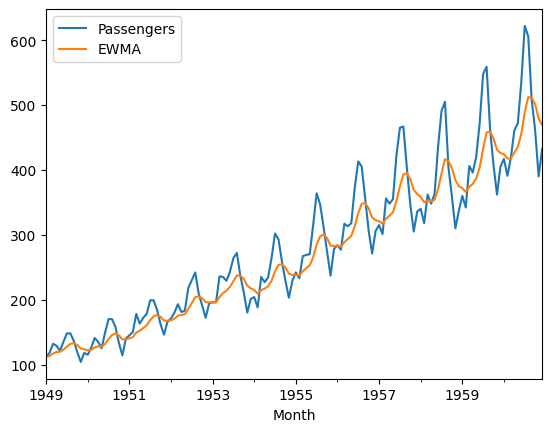

In [10]:
df.plot();

In [11]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

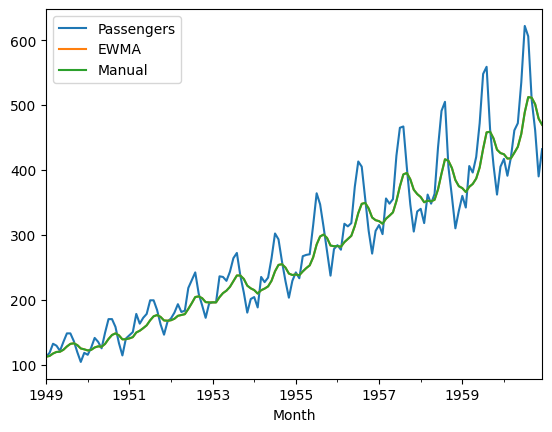

In [12]:
df.plot();

In [13]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [14]:
df.drop('Manual', axis=1, inplace=True)

In [15]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


###Exponential Smoothing

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [17]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [19]:
df.index.freq='MS'

In [20]:
ses = SimpleExpSmoothing(df['Passengers'])

In [21]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [22]:
res

In [23]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [24]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [25]:
np.allclose(df['SES'], res.fittedvalues)

True

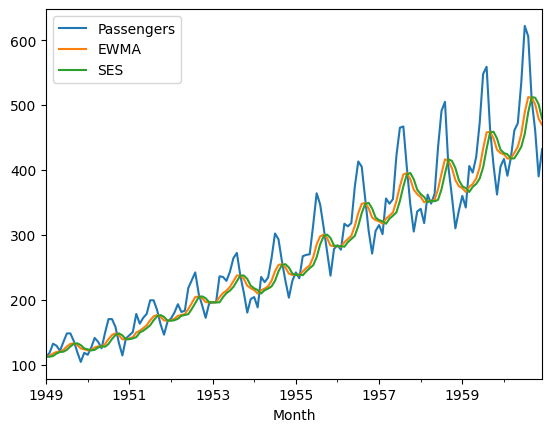

In [26]:
df.plot();

In [27]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [28]:
df['SES=1'] = df['SES'].shift(-1)

##treat this like a machine learning problem

In [29]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [30]:
ses = SimpleExpSmoothing(train['Passengers'])

In [31]:
res = ses.fit()

<ipython-input-32-cfb2732acbd2>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
<ipython-input-32-cfb2732acbd2>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)


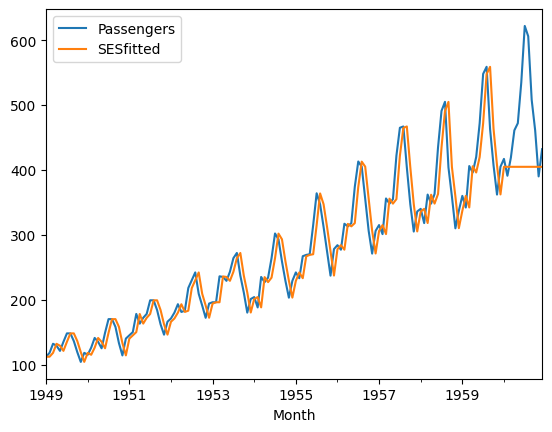

In [32]:
df.loc[:-N_test, 'SESfitted'] = res.fittedvalues
df.loc[-N_test:, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [33]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

###Holt

This is what we did previously just using different libaries and algorithms

In [34]:
from statsmodels.tsa.holtwinters import Holt

In [35]:
holt = Holt(df['Passengers'])

In [36]:
res_h = holt.fit()

In [37]:
df['Holt'] = res_h.fittedvalues

<Axes: xlabel='Month'>

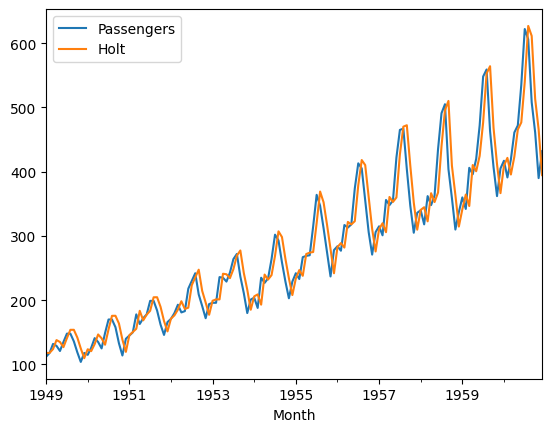

In [38]:
df[['Passengers', 'Holt']].plot()

In [39]:
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[:-N_test, 'Holt'] = res_h.fittedvalues

<ipython-input-39-e5af427c6a94>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'Holt'] = res_h.fittedvalues


In [40]:
df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)

<ipython-input-40-e12628f9a209>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'Holt'] = res_h.forecast(N_test)


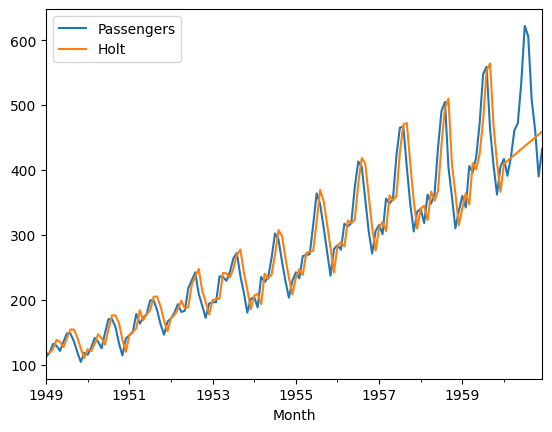

In [41]:
df[['Passengers', 'Holt']].plot();

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [43]:
hw = ExponentialSmoothing(train['Passengers'], trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [44]:
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues

<ipython-input-44-f566a7683658>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues


In [45]:
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)

<ipython-input-45-ebf4db4b1897>:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


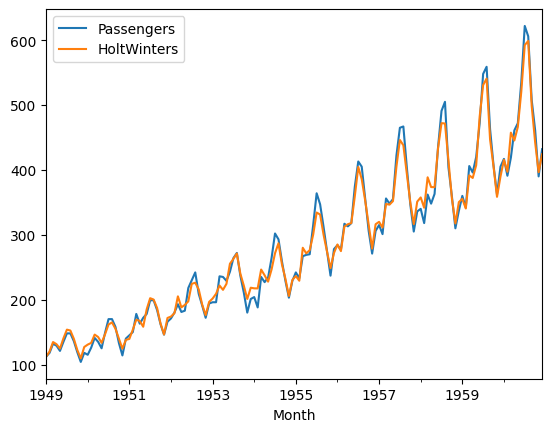

In [46]:
df[['Passengers', 'HoltWinters']].plot();

In [47]:
def rmse(y, t):
  return np.sqrt(np.mean((y-t)** 2))

In [48]:
def mae(y,t):
  return np.mean(np.abs(y-t))

In [53]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624680178005294
Test RMSE: 16.979906128442913


In [54]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.008103165547778
Test RMSE: 13.380462475074248


In [56]:
hw = ExponentialSmoothing(train['Passengers'], trend='add', seasonal='mul', seasonal_periods=12)

<ipython-input-57-928b9e86a336>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-57-928b9e86a336>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


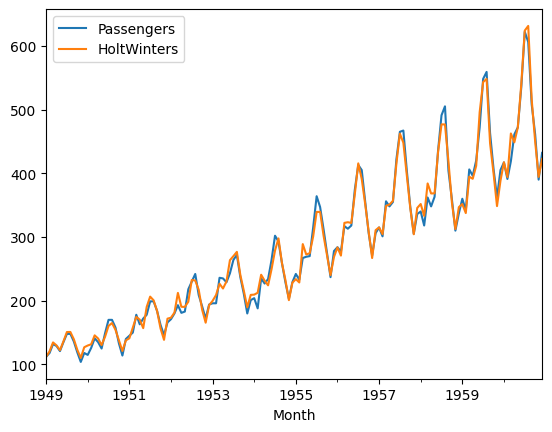

In [57]:
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [58]:
df

,Passengers,EWMA,SES,SES=1,SESfitted,Holt,HoltWinters
Month,,,,,,,
1949-01-01,112,112.000000,112.000000,112.000000,112.000000,118.000000,111.984251
1949-02-01,118,113.200000,112.000000,113.200000,112.000000,117.985093,120.684486
1949-03-01,132,116.960000,113.200000,116.960000,117.970000,123.977513,134.599238
1949-04-01,129,119.368000,116.960000,119.368000,131.929850,137.997464,129.929516
1949-05-01,121,119.694400,119.368000,119.694400,129.014649,134.985294,122.445787
...,...,...,...,...,...,...,...
1960-08-01,606,512.214093,488.767616,512.214093,404.786132,441.046199,631.140847
1960-09-01,508,511.371274,512.214093,511.371274,404.786132,445.558095,515.572341
1960-10-01,461,501.297019,511.371274,501.297019,404.786132,450.069990,449.895842


In [60]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.768021865952148
Test RMSE: 15.807367605699495


In [61]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604261037973922
Test RMSE: 10.299694207748567


In [59]:
hw = ExponentialSmoothing(train['Passengers'], trend='mul', seasonal='mul', seasonal_periods=12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
<ipython-input-62-928b9e86a336>:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
<ipython-input-62-928b9e86a336>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)


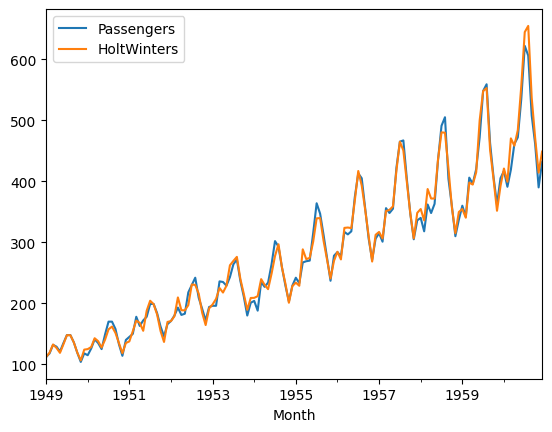

In [62]:
res_hw = hw.fit()
df.loc[:-N_test, 'HoltWinters'] = res_hw.fittedvalues
df.loc[-N_test:, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [63]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.6179248297903
Test RMSE: 25.810226318474683


In [65]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112440339079641
Test MAE: 20.848100067783903
